# 概要

本ファイルでは、KITTIデータセットのカメラ画像に対して、ペインティング処理を実施します。  

手順は次の通りです。  
1. セグメンテーション  
  カメラ画像に対してセグメンテーションを行い、各ピクセルのクラススコアを算出  
　入力：画像  # (H, W, 3)  
　出力：セグメンテーションスコア  # (H * W * C)  


2. 融合 (点群のペインティング)  
  算出したセグメンテーション結果をLidarの点群データに結合し、拡張点群データを作成  
　入力：class_scores, pointcloud(.bin)  # (x,y,z,r)  
　出力：pointcloud_painted.bin  # (x,y,z,r, C1, C2, C3, C4)  


3. 可視化
  - セグメンテーション結果を画像にオーバーラップして表示
  - 点群とセグメンテーション結果を結合した拡張点群を3D散布図に表示

## Output

本ファイルを実行することで、`velodyne_painted`ディレクトリに拡張点群データ(bin)を生成します。

```
└ data
    └ kitti
        └ training
            ├─ image_2
            ├─ calib
            ├─ label_2
            ├─ velodyne
            └─ velodyne_painted <-- 本ファイルにて生成されます
```

# 準備

## ライブラリのインポート

In [1]:
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from tqdm.notebook import tqdm

%matplotlib inline

from utils.calibration_kitti import Calibration, get_calib_from_file
from utils.pointcloud_seg import (create_cyclist, get_segmentation_score,
                                  overlap_seg)
from utils.vis_pointcloud import get_figure_data, view_pointcloud

# インスタンス単体でのペインティング処理

全体の動作を確認するため、インスタンス単体での推論を行います。

## 読み込みファイルのパス設定

In [2]:
idx = 134

# 入力データ
img_path = f"../data/kitti/training/image_2/{idx:0>6}.png"
calib_file = f"../data/kitti/training/calib/{idx:0>6}.txt"
v_path = f"../data/kitti/training/velodyne/{idx:0>6}.bin"

## セグメンテーション

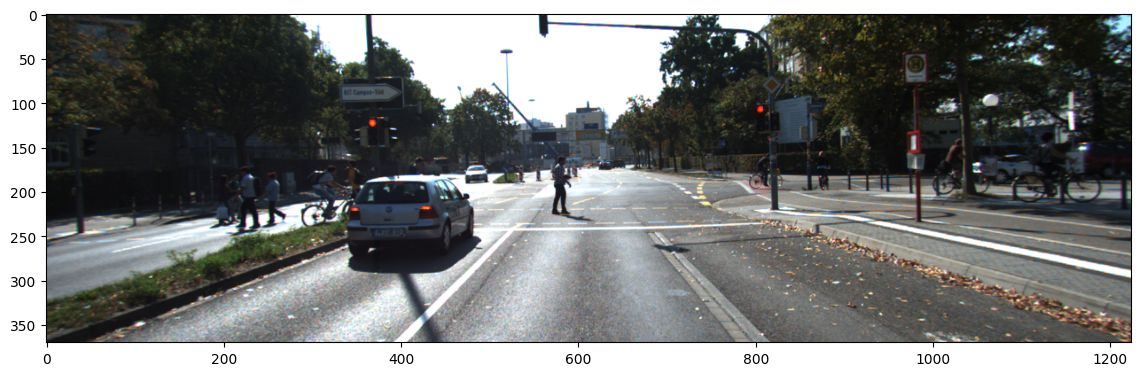

In [3]:
# 画像の確認
img = Image.open(img_path)
plt.figure(figsize=(14, 8))
plt.imshow(img)

### セグメンテーションモデルの定義

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# 学習済みのdeeplabv3モデルをロード
model_seg = torch.hub.load('pytorch/vision:v0.6.0',
                           'deeplabv3_resnet101', pretrained=True)
model_seg.eval()
model_seg.to(device)

print("Segmentation Model Loaded.")

Using cuda device


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Segmentation Model Loaded.


### セグメンテーションモデルの推論

In [5]:
class_scores = get_segmentation_score(img_path, model_seg, device)

print("class_scores shape: ", class_scores.shape)  # (H, W, C)

class_scores shape:  (370, 1224, 4)


### 点群とセグメンテーションスコアの結合

In [6]:
class_num = class_scores.shape[2]
image_h = class_scores.shape[0]
image_w = class_scores.shape[1]

print("Class Num: ", class_num)
print("Image Height: ", image_h)
print("Image Width: ", image_w)

Class Num:  4
Image Height:  370
Image Width:  1224


In [7]:
# 点群データとキャリブレーションデータの読み込み
with open(v_path, "rb") as f:
    pointcloud = np.fromfile(f, dtype=np.float32)
    pointcloud = pointcloud.reshape((-1, 4))

print(pointcloud.shape)  # (N ,4)  4:(x, y, z, r)

calib = Calibration(calib_file)

(122637, 4)


In [8]:
# Lidar座標系 -> カメラ座標系 に変換
points_projected_on_mask, _ = calib.lidar_to_img(pointcloud[:, :3])
points_projected_on_mask.shape

(122637, 2)

In [9]:
# 画像範囲内の点群を抽出
true_where_x_on_img = (0 < points_projected_on_mask[:, 0]) & \
                      (points_projected_on_mask[:, 0] < image_w)
true_where_y_on_img = (0 < points_projected_on_mask[:, 1]) & \
                      (points_projected_on_mask[:, 1] < image_h)
true_where_point_on_img = true_where_x_on_img & true_where_y_on_img

points_projected_on_mask = points_projected_on_mask[true_where_point_on_img]
# 小数点以下切り捨て
points_projected_on_mask = np.floor(points_projected_on_mask).astype(int)

print(points_projected_on_mask.shape)

(39000, 2)


In [10]:
# 点群データとセグメンテーションを結合し、拡張点群データを作成

# point_projected_on_mask は x,y が画像座標で、cols, rows であるのに対し、
# class_score は (rows, cols) なので、以下のインデックスの値は 1 → 0 と逆になる
point_scores = class_scores[points_projected_on_mask[:, 1],
                            points_projected_on_mask[:, 0]]
point_scores = point_scores.reshape(-1, class_num)  # (N, class_num)

painted_lidar = np.concatenate((pointcloud,
                                np.zeros((pointcloud.shape[0], class_num))), axis=1)

painted_lidar[true_where_point_on_img, -class_num:] = point_scores
painted_lidar = painted_lidar[true_where_point_on_img]
painted_lidar = create_cyclist(painted_lidar)  # personとbikeクラスからcyclistを作成

painted_lidar = painted_lidar.astype(np.float32)
painted_lidar = painted_lidar[painted_lidar[:, 0] > 0, :]  # x > 0 を抽出

print(painted_lidar.shape)

(19075, 8)


### 可視化

#### セグメンテーション + 画像

セグメンテーション結果を画像にオーバーラップして表示します。

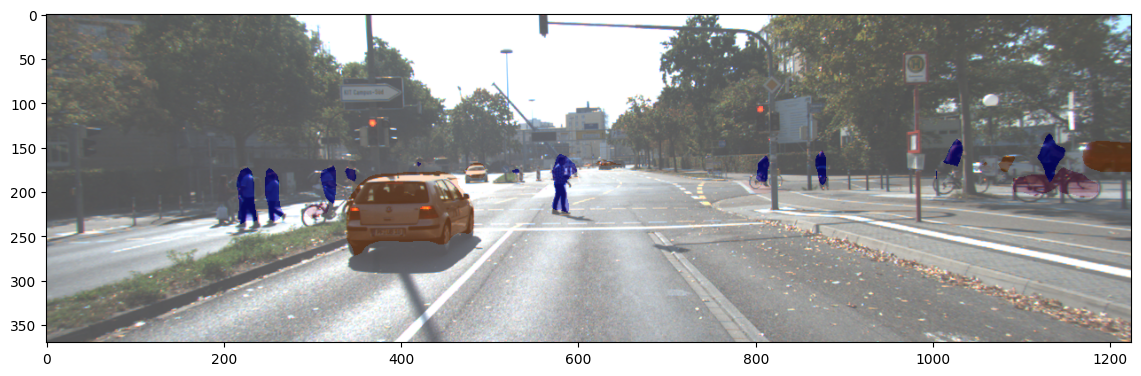

In [11]:
img = Image.open(img_path)
img_np = np.array(img)

img_seg = overlap_seg(img_np,
                      class_scores,
                      opacity=0.3)

plt.figure(figsize=(14, 8))
plt.imshow(img_seg)

#### セグメンテーション + 点群

点群とセグメンテーション結果を結合した拡張点群を3D散布図に表示します。

In [12]:
pc_data = painted_lidar[::4]  # 可視化のため1/4に間引き

segcolor_dict = {0: "darkgray", 1: "deeppink", 2: "orange", 3: "blue"}

points = pc_data[:, :3]  # (x, y, z) を抽出
color_idx_arr = np.argmax(pc_data[:, 4:], axis=1)  # Classを抽出
color_idx_arr = [segcolor_dict[i] for i in color_idx_arr]

fig = view_pointcloud(points, color_idx_arr, mode="front")
fig.show()

# trainigの全画像と点群に対してペインティング処理

拡張点群データ(bin)を生成し、`velodyne_painted` ディレクトリに保存します。

In [ ]:
# 保存先ディレクトリの設定
save_path = "../data/kitti/training/velodyne_painted/"

Path(save_path).mkdir(exist_ok=True)

In [ ]:
for idx in tqdm(range(7481)):

    img_path = f"../data/kitti/training/image_2/{idx:0>6}.png"
    calib_file = f"../data/kitti/training/calib/{idx:0>6}.txt"
    v_path = f"../data/kitti/training/velodyne/{idx:0>6}.bin"

    # セグメンテーションの実行
    class_scores = get_segmentation_score(img_path, model_seg, device)

    class_num = class_scores.shape[2]
    image_h = class_scores.shape[0]
    image_w = class_scores.shape[1]

    # 点群データとキャリブレーションデータの読み込み
    with open(v_path, "rb") as f:
        pointcloud = np.fromfile(f, dtype=np.float32)
        pointcloud = pointcloud.reshape((-1, 4))

    calib = Calibration(calib_file)

    # Lidar座標系 -> カメラ座標系 に変換
    points_projected_on_mask, _ = calib.lidar_to_img(pointcloud[:, :3])

    # 画像範囲内の点群を抽出
    true_where_x_on_img = (0 < points_projected_on_mask[:, 0]) & (
        points_projected_on_mask[:, 0] < image_w)
    true_where_y_on_img = (0 < points_projected_on_mask[:, 1]) & (
        points_projected_on_mask[:, 1] < image_h)
    true_where_point_on_img = true_where_x_on_img & true_where_y_on_img

    points_projected_on_mask = points_projected_on_mask[true_where_point_on_img]
    # using floor so you don't end up indexing num_rows+1th row or col
    points_projected_on_mask = np.floor(points_projected_on_mask).astype(int)

    # 点群データとセグメンテーションを結合し、拡張点群データを作成
    point_scores = class_scores[points_projected_on_mask[:, 1],
                                points_projected_on_mask[:, 0]]
    point_scores = point_scores.reshape(-1, class_num)  # (N, class_num)

    painted_lidar = np.concatenate(
        (pointcloud, np.zeros((pointcloud.shape[0], class_num))), axis=1)

    painted_lidar[true_where_point_on_img, -class_num:] = point_scores
    painted_lidar = painted_lidar[true_where_point_on_img]
    painted_lidar = create_cyclist(painted_lidar)  # personとbikeクラスからcyclistを作成

    painted_lidar = painted_lidar.astype(np.float32)
    painted_lidar = painted_lidar[painted_lidar[:, 0] > 0, :]  # x > 0 を抽出

    # 点群データbinを保存
    save_name = Path(save_path).joinpath(f"{idx:0>6}.bin")
    painted_lidar.tofile(save_name)

以上